# Confocal DOF
According to Leica hardware configuration, for objective 10x, wavelength 488 nm, the depth resolution should be:
$$ \delta z = 4768 \mathrm{\ mm}$$
While the depth of focus is 
$$ DOF \equiv z_R = \frac{\pi w_0^2}{\lambda} = \frac{\lambda}{\pi A^2}$$
Retrieved from https://www.newport.com/n/gaussian-beam-optics using $A = \frac{D}{2 F}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from jupyterthemes import jtplot

In [25]:
jtplot.style('default')
from invisible_cities.core.system_of_units import nanometer as nm
from invisible_cities.core.system_of_units import mm

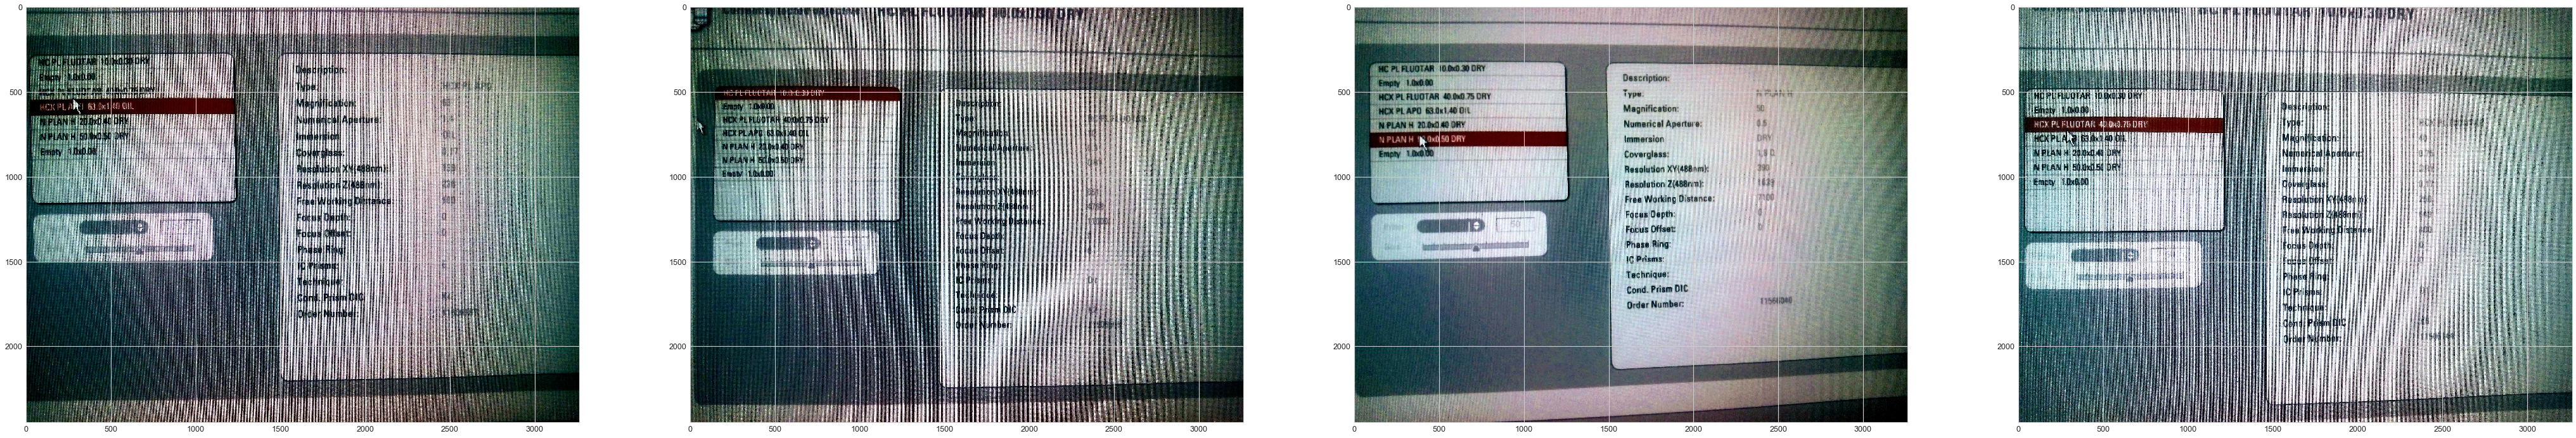

In [36]:
dir_def = f"/Users/pabloherrero/Documents/confocal/objective_specs/"
f = dir_def + '*x.jpg'
f = glob.glob(os.path.expandvars(f))
fig, ax = plt.subplots(1, 4)
for i,im in enumerate(f):
    b = plt.imread(im)
    ax[i].imshow(b, )
fig.set_figheight(16)
fig.set_figwidth(72)

##### Wavelength cyan and Numerical aperture for objectives (10x, 20x, 50x and 63x respectively)

In [6]:
lam = 488 * nm
A = [0.3, 0.75, 0.5, 0.9]

Assuming gaussian beam

In [8]:
def dof (A : float, lam: float = 488 * nm) -> float:
    """Depth of focus in [mm] as function of lambda and numerical aperture A"""
    zr = lam/(np.pi*A**2)
    return zr / nm

In [39]:
[dof(a) for a in A]

[1725.9469384187762, 276.1515101470042, 621.3408978307594, 191.77188204653066]

## Depth resolution (AFWHM$_{conf}$)

From https://doi.org/10.1111/j.1365-2818.2011.03549.x, assuming infinitely small pinhole aperture
$$ \delta z = 0.64 \frac{\lambda}{n - \sqrt{n^2-NA^2}} $$

In [61]:
def depth_res(A : float, lam: float = 488 * nm,
             n : float = 1) -> float:
    dz = 0.64*lam/(n - np.sqrt(n**2 - A**2))
#     dz = 1.4*lam*n/A**2
    return dz / nm

In [62]:
[depth_res(a) for a in A]

[6780.603237628229, 922.4893553207525, 2331.188216439823, 553.6507800057558]

## LFWHM$_{conf}$
(Lateral) FWHM
From  https://doi.org/10.1111/j.1365-2818.2011.03549.x, 
$$ \delta r = 0.37 \frac{\lambda}{NA}$$

In [9]:
def lateral_res(A : float, lam: float = 488 * nm) -> float:
    dr = 0.37*lam/A
    return dr / nm

In [10]:
lateral_res(A = 0.5)

361.12000000000006

# $\delta V$ & $\delta m$

Choose from now on maximum NA objective (50x, NA = 0.5) and mininum PH aperture (0.5 AU)

## $\delta V$
$$ \delta V = \frac{\delta r^2}{2} \cdot \delta z $$

In [22]:
d = lateral_res(0.5)

In [85]:
from sabat.sbt_types import CircularFoV
d = lateral_res(A = 0.5) * nm / mm
r = dof_leica(0.5, 0.5) * nm / mm
CircularFoV(2*d, r)


        FOV; d = 7.2e-04 mm; r = 3.6e-04 mm; z = 3.8e+00 mm;
        area = 4.1e-07 mm2 volume = 1.6e-06 mm3
        

In [88]:
dV =  dof_leica(0.5, 0.5) * np.pi * lateral_res(0.5)**2
print ('dV = {} nm^3 = {} um^3 = {} L'.format(dV, dV*micron3, dV/1E24))

dV = 1573235446516.4573 nm^3 = 1573.2354465164574 um^3 = 1.5732354465164574e-12 L


## $\delta m$ 

 - Assume constant distribution in $\delta V$ 
 - Assume solution concentration stays constant after injection
$$ \rho = \frac{\delta m}{\delta V} = c \left[\frac{mol}{L}\right] \cdot M \left[\frac{g}{mol}\right] $$
density = concentration $\times$ molar mass

In [1]:
from invisible_cities.core.system_of_units import *

c = 0.5E-3 
M = 332.31
rho = c * M

print('rho ={} g/L'.format(rho))

rho =0.166155 g/L


In [90]:
dm = rho * dV / 1E24
print ('Mass in FoV = {} g'.format(dm))

Mass in FoV = 2.61400935615942e-13 g


## $\delta N$
Number of molecules in $\delta V$:
$$ \delta N = c \cdot N_A \cdot \delta V $$
$N_A$ : Avogadro constant

In [95]:
NA = 6.022E23 # Avogadro constant
N = c * NA * dV / 1E24
print ('Number of molecules in FoV = {0:.1e} molecs'.format(N))

Number of molecules in FoV = 4.7e+08 molecs


# DOF From Leica sw

Dependence on pinhole aperture AU
$$DOF = \sqrt{\left(\frac{\lambda n}{NA^2}\right)^2 + \left(\frac{AU \times n \sqrt{2} \times 1.22 \lambda}{NA^2}\right)^2}$$

In [4]:
def dof_leica(A: float = 0.3, lam: float = 488 * nm, n: float = 1,
             U: float = 0.95) -> float:
    dof = np.sqrt((lam*n/A**2)**2 + (U*n*np.sqrt(2)*1.22*lam/A**2)**2)
    return dof / nm

In [15]:
[dof_leica(A = a) for a in A]

[10410.895414153598, 1665.7432662645758, 3747.922349095296, 1156.7661571281778]

In [5]:
dof_leica(A = 0.5, U = 0.5)

2577.970565541818